In [572]:
from __future__ import division, print_function, absolute_import
import csv
import pandas
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
import os
import xml.etree.ElementTree as etree
import cobra
import numpy as np
from itertools import chain
from cobra.util import solver as sutil
from cobra.core.solution import get_solution
from optlang.symbolics import add, Zero
import pandas as pd
import os
from os.path import join
import matplotlib.pyplot as plt
from cobra.medium import minimal_medium
# Press ⌃R to execute it or replace it with your code.
# Press Double ⇧ to search everywhere for classes, files, tool windows, actions, and settings.
from cobra.flux_analysis import production_envelope
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis
import matplotlib.pyplot as plt
from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model
import math

In [573]:
## pareto
objective1={''}
objective2={''}
pareto_range = (0.0, 1.001)  # for some reason you need to pick a number higher than 1).
pareto_step_size = 0.01
analysis_type = 'pareto'
metric = 'manhattan'
rxn2avoid = {''}
primary=[]
solver='gurobi'
constants = {'deltaC_CO2': 0.0055, 'D_H2O_0': 2.13E-05, 'D_CO2_0': 1.33E-05, 'mid_day': 6, 'deltaT': 2,
             'FeasTol': 1e-03, 'OptTol': 1e-03}
def pareto_analysis(model, objective1=objective1, objective2=objective2, pareto_range=pareto_range, metric=metric,primary=primary):
    reaction_obj1 = model.reactions.get_by_id(objective1)
    reaction_obj2 = model.reactions.get_by_id(objective2)
    result_list = []
    solution_primary=[]
    model.objective = {}
    reaction_obj1.objective_coefficient = 1
    solution = model.optimize()
    print("\nSolving model (FBA) for determining objective 1 flux...")
    max_obj1 = dict(solution.fluxes)[objective1]
    print("Max {0}: {1}".format(objective1, max_obj1))
    # change objective
    reaction_obj1.objective_coefficient = 0
    reaction_obj2.objective_coefficient = 1
    print("\nSolving all iterations for Pareto frontier (FBA)...")
    for pareto in np.arange(pareto_range[0], pareto_range[1], pareto_step_size):
        if pareto == 1:
            reaction_obj1.lower_bound = max_obj1 * pareto  # * 0.999 # we need to add a bit of slack as the quadratic optimization is less accurate than the linear couterpart
        else:
            reaction_obj1.lower_bound = max_obj1 * pareto  # * 0.9999
        sol = model.optimize(objective_sense='maximize')
        # fix this minimal water loss value
        reaction_obj2.bounds = (sol.get_primal_by_id(objective2), sol.get_primal_by_id(objective2))
        if metric == 'manhattan':
            solution = cobra.flux_analysis.pfba(model)
            primary_dark=[]
            for i in model.reactions:
                primary_dark.append(i.id)
            solution_primary.append(solution.fluxes[primary_dark])
            reaction_obj2.bounds = (0, 1000.0)
        elif metric == 'euclidean':

            # make copy because that is easier that reverting all the solver settings
            copy_model = model.copy()
            model.solver = solver

            FeasTol = float(constants['FeasTol'])
            OptTol = float(constants['OptTol'])

            copy_model.solver.configuration.tolerances.feasibility = FeasTol
            copy_model.solver.configuration.tolerances.optimality = OptTol

            rxnlist = [r for r in copy_model.reactions if r.id not in rxn2avoid]

            obj_vars = chain.from_iterable([r.flux_expression ** 2] for r in rxnlist)
            copy_model.objective = copy_model.problem.Objective(add(obj_vars), direction='min')

            print('\nSolving quadratic minimisation of sum of fluxes')
            #print(solver)
            solution = copy_model.optimize(objective_sense=None)
            #result_list.append([pareto, solution[objective1], solution[objective2]])
        reaction_obj2.bounds = (0, 1000.0)
    #return result_list
    return solution_primary

In [574]:
## Plots
#model = cobra.io.load_matlab_model(join('/home/subasree/Desktop/Models_to_work/alpha_day_DM.mat'))
model_rs = cobra.io.load_matlab_model(join('alpha_day_RS_DM.mat'))
core_model=model_rs


In [575]:
core_model.metabolites.query('CARBON_DIOXIDE')

[<Metabolite CARBON_DIOXIDE_c at 0x7fa397fed1c0>,
 <Metabolite CARBON_DIOXIDE_e at 0x7fa397fed1f0>,
 <Metabolite CARBON_DIOXIDE_m at 0x7fa397fed220>,
 <Metabolite CARBON_DIOXIDE_p at 0x7fa397fed250>,
 <Metabolite CARBON_DIOXIDE_x at 0x7fa397fed280>,
 <Metabolite CARBON_DIOXIDE_r at 0x7fa38231e550>]

In [576]:
##Constraints
rubisco = core_model.problem.Constraint(3 * core_model.reactions.get_by_id("RXN_961_p").flux_expression - core_model.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression,lb=0, ub=0,)
#core_model.add_cons_vars([rubisco])

atp_nadph_03 = core_model.problem.Constraint(3 * (core_model.reactions.get_by_id("NADPHoxm_tx").flux_expression + core_model.reactions.get_by_id("NADPHoxc_tx").flux_expression + core_model.reactions.get_by_id("NADPHoxp_tx").flux_expression) - core_model.reactions.get_by_id("ATPase_tx").flux_expression, lb=0, ub=0)
core_model.add_cons_vars(atp_nadph_03)


In [577]:
## plot pareto plot
objective1 =  'DM_HYDROGEN_PEROXIDE_cell' #ho2_rad_p_demand AraCore_Biomass_tx DM_HS_cell DM_CPD0-1395_cell'DM_SUPER_OXIDE_cell'#'DM_NITRIC-OXIDE_cell'#'DM_CPD-12377_cell'#'DM_HYDROGEN_PEROXIDE_cell'
objective2 =  'AraCore_Biomass_tx'
solution_primary=pareto_analysis(core_model, objective1 = objective1, objective2=objective2, pareto_range = pareto_range, metric = metric)
#pd.DataFrame(result_list).to_excel('results.xlsx')



Solving model (FBA) for determining objective 1 flux...
Max DM_HYDROGEN_PEROXIDE_cell: 150.0

Solving all iterations for Pareto frontier (FBA)...


In [588]:
data=pd.DataFrame(solution_primary)
data_t=data.T
solution_frame=pd.DataFrame(data_t.iloc[:,100])
solution_frame.columns=['fluxes']

In [589]:
#Creating an empty dataframe
df_p = []
df_c = []
budget_metabolites = ["CARBON_DIOXIDE_c", "CARBON_DIOXIDE_m", "CARBON_DIOXIDE_p", "CARBON_DIOXIDE_x","CARBON_DIOXIDE_e","CARBON_DIOXIDE_r"]
compartment = ["_c", "_m", "_p", "_x","_e","_r"]

#budget_metabolites=["OXYGEN_MOLECULE_c","OXYGEN_MOLECULE_m","OXYGEN_MOLECULE_p","OXYGEN_MOLECULE_x","OXYGEN_MOLECULE_e","OXYGEN_MOLECULE_v","OXYGEN_MOLECULE_r","OXYGEN_MOLECULE_g","OXYGEN_MOLECULE_n"]
#compartment = ["_c", "_m", "_p", "_x", "_e", "_v", "_r", "_g", "_n"]

c3_model=core_model
for (a,com) in zip(budget_metabolites,compartment):
    i = c3_model.metabolites.get_by_id(a).summary()
    p = i.producing_flux
    c = i.consuming_flux

# Retrieving the reactions using pandas and filtering the transport reactions
    #producer = p.loc[:,"reaction"].str.contains(com)
    producer = p.loc[:,"reaction"].str.endswith(com) 
    producer_rs=p.loc[:,"reaction"].str.startswith("RS_")
    producer_tr=p.loc[:,"reaction"].str.endswith("_tx")
    producer = p[producer]
    producer_rs=p[producer_rs]
    producer_tr=p[producer_tr]
    df_p.append(producer)
    df_p.append(producer_rs)
    df_p.append(producer_tr)
    producer_df = pd.concat(df_p)
        
# Retrieving the reactions using pandas
    consumer = c.loc[:,"reaction"].str.endswith(com)
    consumer_rs=c.loc[:,"reaction"].str.startswith("RS_")
    consumer = c[consumer]
    consumer_rs=c[consumer_rs]
    df_c.append(consumer)
    df_c.append(consumer_rs)
    consumer_df = pd.concat(df_c)
consumers=list(consumer_df['reaction'])
producers=list(producer_df.index)

In [590]:
#consumers.extend(['CYTOCHROME_C_OXIDASE_RXN_mc','CYTOCHROME_C_OXIDASE_RXN_mi'])

In [591]:
def budget_plot(solution_frame, producers, consumers):
    
    #Get flux values from the simulation for metabolite consuming/producing reactions
    producers_df = solution_frame.loc[producers,:]
    consumers_df = solution_frame.loc[consumers,:]

    #Get values with negative flows: producing reactions with negative flow are consuming and vice-versa
    negative_producers = list(producers_df[producers_df["fluxes"] < 0].index)
    negative_consumers = list(consumers_df[consumers_df["fluxes"] < 0].index)


    #Add reactions to correct list
    consumers.extend(negative_producers)
    producers.extend(negative_consumers)

    #Remove reactions with negative flux from old list
    def remove_items(test_list, item):
        res = [i for i in test_list if i != item]
        return res

    for item in negative_producers:
        producers = remove_items(producers, item)

    for item in negative_consumers:
        consumers = remove_items(consumers, item)

    """
    Get producing reactions and fluxes
    """

    #Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
    producers_df = solution_frame.loc[producers,:]
    #Make all values positive (disregard directionality)
    print(producers_df)
    producers_df["fluxes"] = producers_df["fluxes"].abs()
    #Remove reactions with zero flux
    producers_df = producers_df[(producers_df.T != 0).all()]
    producers_df


    """
    Get consuming reactions and fluxes
    """

    #Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
    consumers_df = solution_frame.loc[consumers,:]
    print(consumers_df)
    #Make all values positive (disregard directionality)
    consumers_df["fluxes"]  = consumers_df["fluxes"].abs()
    #Remove reactions with zero flux3_P_SERINE_
    consumers_df = consumers_df[(consumers_df.T != 0).all()]
    consumers_df

    """
    Concatenate producer and consumer dataframes
    """

    producers_df["Status"] = "Producer"
    consumers_df["Status"] = "Consumer"

    frame = [producers_df, consumers_df]

    all_reactions = pd.concat(frame)

    all_reactions["label"] = all_reactions.index

    #Export full dataframe to csv
    #all_reactions.to_csv("budget_plot.csv", header=True)

    #Correct Budget stoichiometry
    atp_stoi=[]
    for i in all_reactions['label']:
        for met in budget_metabolites:
            try:
                rxn=c3_model.reactions.get_by_id(i).get_coefficient(met)
                atp_stoi.append(abs(rxn))
            except KeyError:
                continue

    new_flux = all_reactions["fluxes"] * atp_stoi

    all_reactions.insert(3,'coefficient', atp_stoi)
    print(all_reactions)
    all_reactions.insert(4,'new_flux', new_flux)
    print(all_reactions)
    """
    Fluxes in consumption and production should be equal
    """

    #Sum the flux values
    print("Sum of fluxes: {}".format(all_reactions.groupby(["Status"]).new_flux.sum()))

    """
    Pick the colors - using random
    """

    import random
    import matplotlib.pyplot as plt


    #Defining the nº of colors
    number_of_colors = len(all_reactions.index)

    #Getting a list of colors
    random.seed(177)
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                for i in range(number_of_colors)]

    #Getting list of reactions
    reaction_list = list(all_reactions.index)

    #Build color dictionary
    color_dict = {}
    for i in range(len(reaction_list)):
        color_dict[reaction_list[i]] = color[i]

    """
    Plot the pivot table and barplot
    """
    fig = plt.figure()
    plt.style.use('fast')

    chart = all_reactions.pivot_table(index="Status", columns="label", values="new_flux")
    chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "Flux", color = color_dict)
    plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5, 0.5, 0.5), ncol = 2)
    #plt.title("Platoquinone Turnover in the Bundle Sheath Cell")
    figsize = [15, 20] #To prevent the cropping of the image
    fig.set_size_inches(w=100,h=70)
    fig.tight_layout()
    #plt.savefig('full_max_o2s.pdf')
    plt.show()
    chart



                                           fluxes
4_HYDROXYPHENYLPYRUVATE_DIOXYGENASE_RXN_c     0.0
6PGLUCONDEHYDROG_RXN_c                        0.0
GLUTDECARBOX_RXN_c                            0.0
IPP_biosynthesis_c                            0.0
ISOCITDEH_RXN_c                               0.0
MALIC_NADP_RXN_c                              0.0
PEPCARBOXYKIN_RXN_c                           0.0
RXN_5641_c                                    0.0
UDP_GLUCURONATE_DECARBOXYLASE_RXN_c           0.0
UREASE_RXN_c                                  0.0
1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m           0.0
1_PERIOD_2_PERIOD_1_PERIOD_25_RXN_m           0.0
1_PERIOD_2_PERIOD_1_PERIOD_2_RXN_m            0.0
2KETO_3METHYLVALERATE_RXN_m                   0.0
2KETO_4METHYL_PENTANOATE_DEHYDROG_RXN_m       0.0
2OXOGLUTARATEDEH_RXN_m                        0.0
2_KETO_ADIPATE_DEHYDROG_RXN_m                 0.0
GCVMULTI_RXN_m                                0.0
ISOCITDEH_RXN_m                               0.0


<Figure size 7200x5040 with 0 Axes>

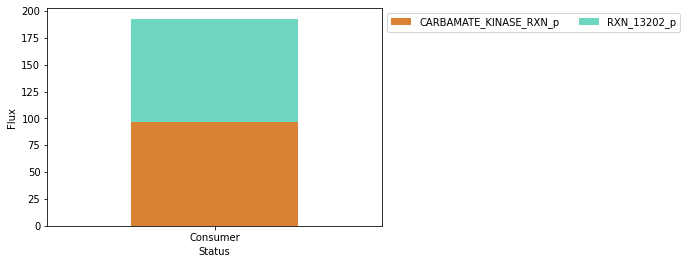

In [592]:
final_budget=budget_plot(solution_frame, producers, consumers)